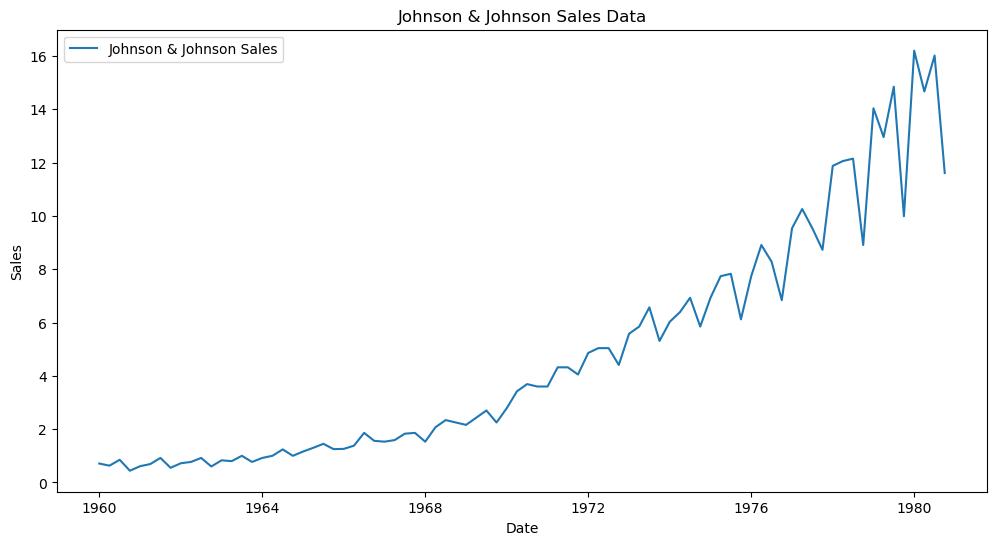

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import product
import pmdarima as pm
from scipy.stats import boxcox
from numpy.fft import fft

# Load Dataset
data = pd.read_csv('jj.csv')

# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Plot the Original Data
plt.figure(figsize=(12,6))
plt.plot(data['data'], label='Johnson & Johnson Sales')
plt.title('Johnson & Johnson Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


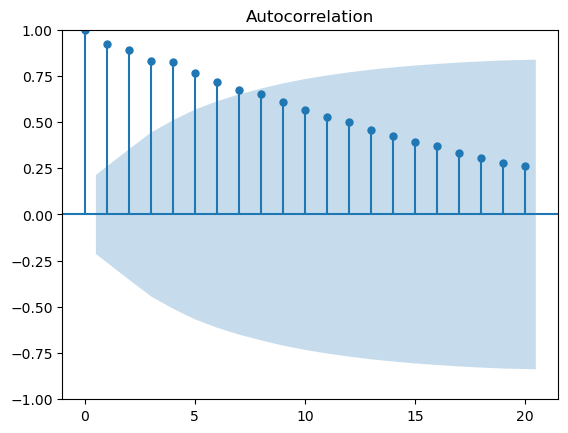

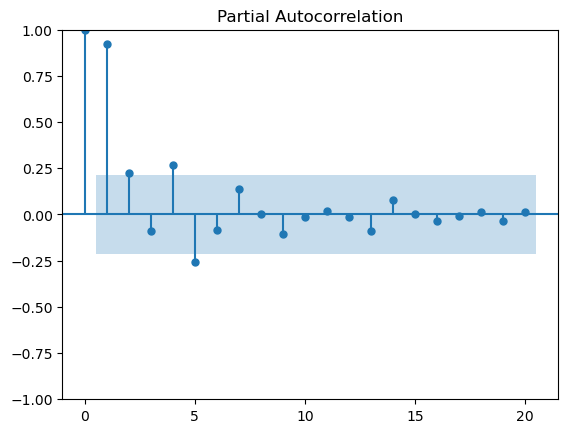

ADF Statistic: 2.742016573457468
p-value: 1.0


In [2]:
# ACF and PACF Plots
plot_acf(data['data'])
plt.show()

plot_pacf(data['data'])
plt.show()

# Augmented Dickey-Fuller Test
adf_result = adfuller(data['data'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


Optimal Lambda for Box-Cox Transformation: 0.050710314712169455


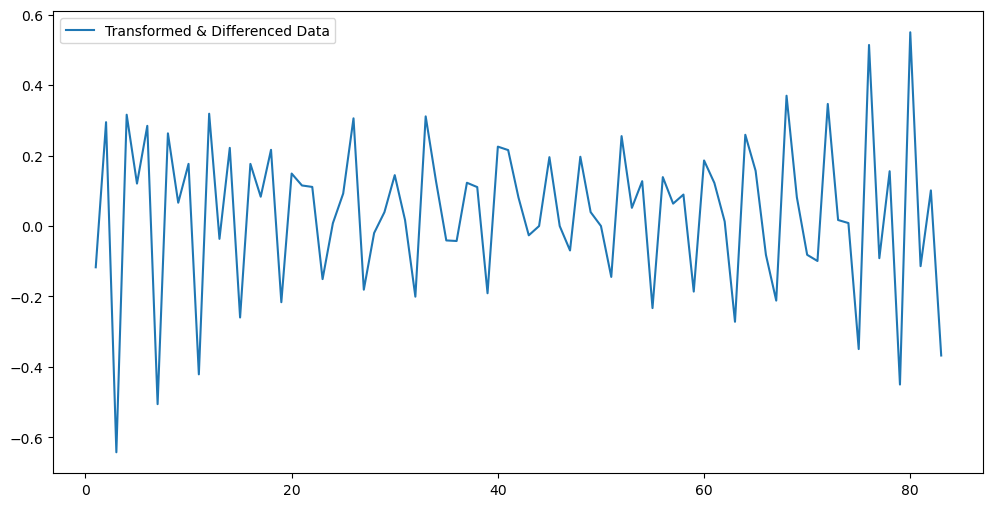

ADF Statistic after Transformation: -4.381473550980534
p-value after Transformation: 0.00032006195939558794


In [3]:
# Box-Cox Transformation (Best Lambda)
data_transformed, lam = boxcox(data['data'])
print(f'Optimal Lambda for Box-Cox Transformation: {lam}')

# Differencing
data_diff = pd.Series(data_transformed).diff().dropna()

# Plot Transformed & Differenced Data
plt.figure(figsize=(12,6))
plt.plot(data_diff, label='Transformed & Differenced Data')
plt.legend()
plt.show()

# Re-Test Stationarity
adf_result_diff = adfuller(data_diff)
print(f'ADF Statistic after Transformation: {adf_result_diff[0]}')
print(f'p-value after Transformation: {adf_result_diff[1]}')


In [4]:
p = d = q = range(0, 8)
pdq = list(product(p, [1], q)) # d=1 for differencing

aic_values = []
params = []

for param in pdq:
    try:
        model = ARIMA(data_transformed, order=param)
        model_fit = model.fit()
        aic_values.append(model_fit.aic)
        params.append(param)
    except:
        continue

best_param_manual = params[np.argmin(aic_values)]
print(f'Best ARIMA(p,d,q) Parameters (Manual Search): {best_param_manual}')


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximu

Best ARIMA(p,d,q) Parameters (Manual Search): (4, 1, 3)


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
auto_model = pm.auto_arima(data['data'], seasonal=False, trace=True)
print(f'Best ARIMA(p,d,q) Parameters (Auto ARIMA): {auto_model.order}')


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=240.020, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=297.285, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=264.953, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=255.333, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=295.995, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=238.454, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=229.503, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=259.465, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=251.412, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=228.486, Time=0.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.21 sec

B

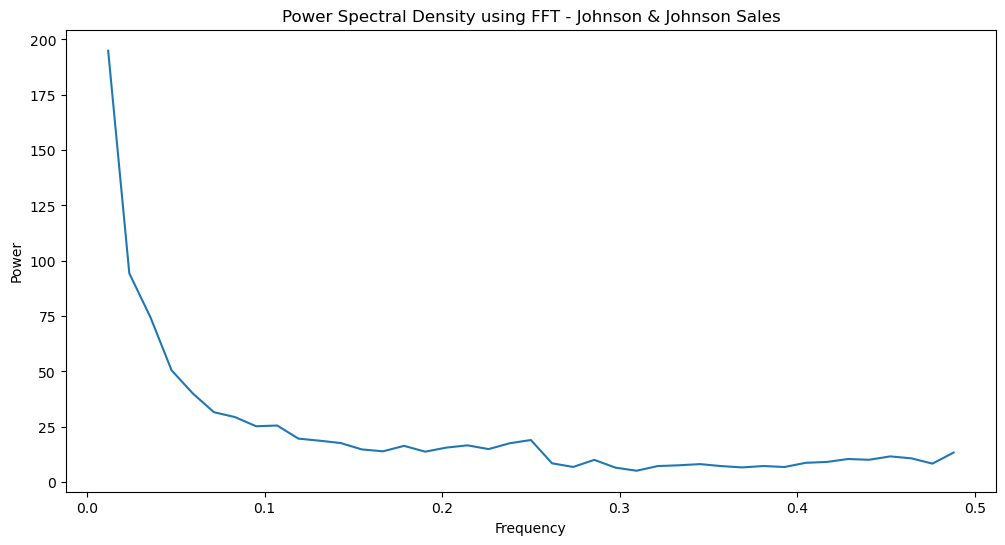

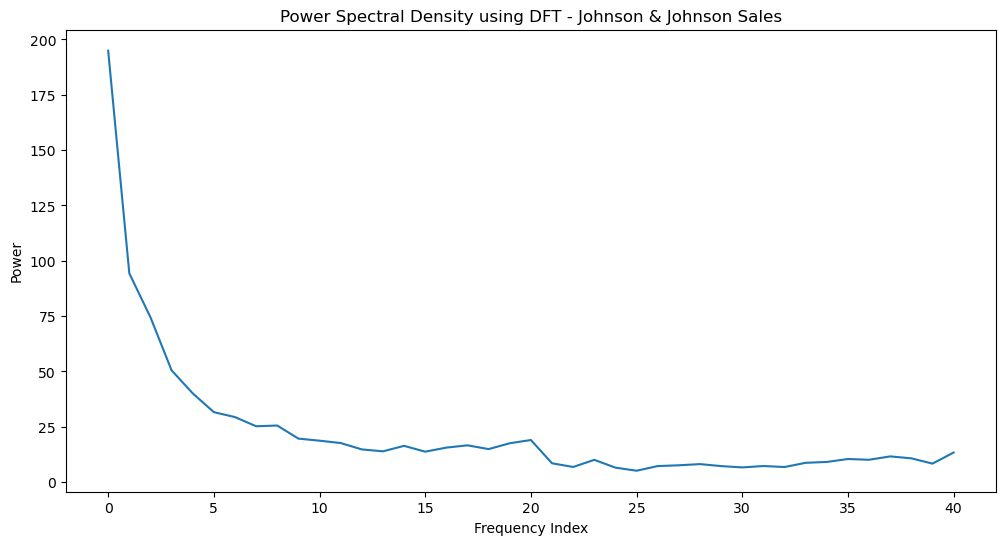

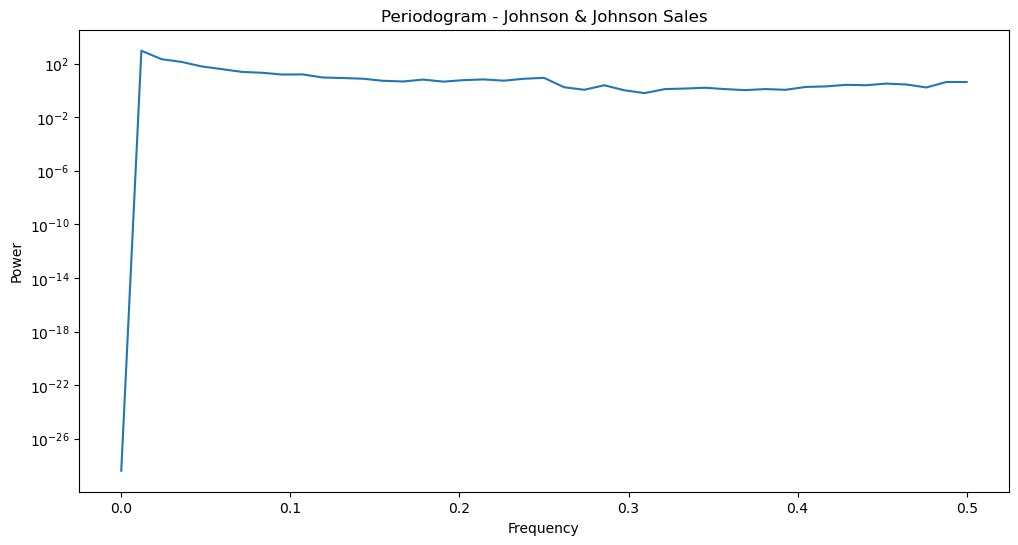

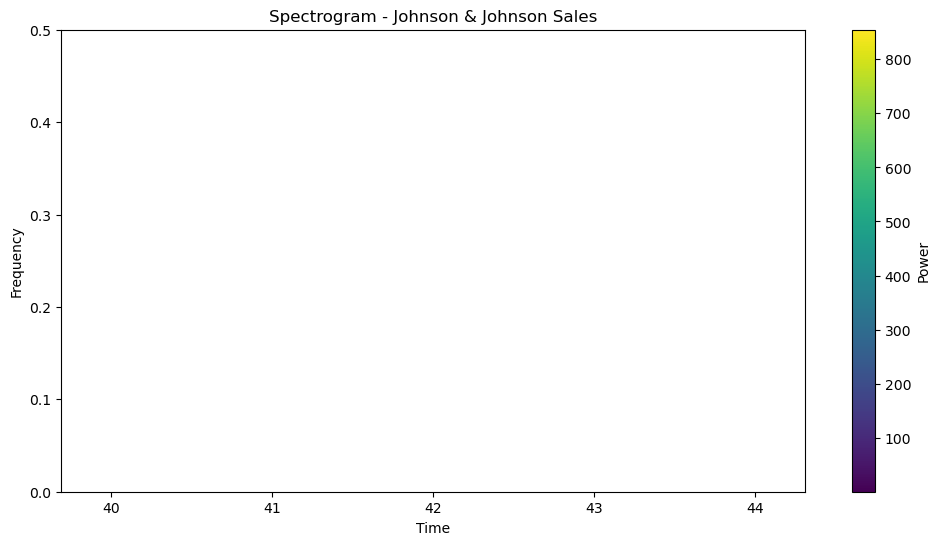

In [7]:
from scipy.signal import periodogram, spectrogram

series = data['data'].values

# Apply FFT (Fast Fourier Transform)
fft_vals = np.fft.fft(series)
fft_freq = np.fft.fftfreq(len(series))

# Power from FFT
fft_power = np.abs(fft_vals)

# Plot Power Spectral Density using FFT
plt.figure(figsize=(12, 6))
plt.plot(fft_freq[1:len(fft_freq)//2], fft_power[1:len(fft_power)//2])
plt.title('Power Spectral Density using FFT - Johnson & Johnson Sales')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

# Apply DFT (Manual Discrete Fourier Transform)
def DFT(x):
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    exponent = -2j * np.pi * k * n / N
    return np.dot(np.exp(exponent), x)

dft_vals = DFT(series)
dft_power = np.abs(dft_vals)

# Plot Power Spectral Density using DFT
plt.figure(figsize=(12, 6))
plt.plot(dft_power[1:len(dft_power)//2])
plt.title('Power Spectral Density using DFT - Johnson & Johnson Sales')
plt.xlabel('Frequency Index')
plt.ylabel('Power')
plt.show()

# Periodogram using scipy
freqs, power = periodogram(series)

plt.figure(figsize=(12, 6))
plt.semilogy(freqs, power)
plt.title('Periodogram - Johnson & Johnson Sales')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

# Spectrogram Visualization
f, t, Sxx = spectrogram(series)

plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.title('Spectrogram - Johnson & Johnson Sales')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(label='Power')
plt.show()


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   84
Model:                 ARIMA(4, 1, 3)   Log Likelihood                  76.767
Date:                Thu, 10 Apr 2025   AIC                           -137.535
Time:                        23:31:29   BIC                           -118.184
Sample:                             0   HQIC                          -129.760
                                 - 84                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0038      0.061     -0.062      0.950      -0.123       0.116
ar.L2          0.0119      0.052      0.230      0.818      -0.089       0.113
ar.L3          0.0328      0.048      0.683      0.4

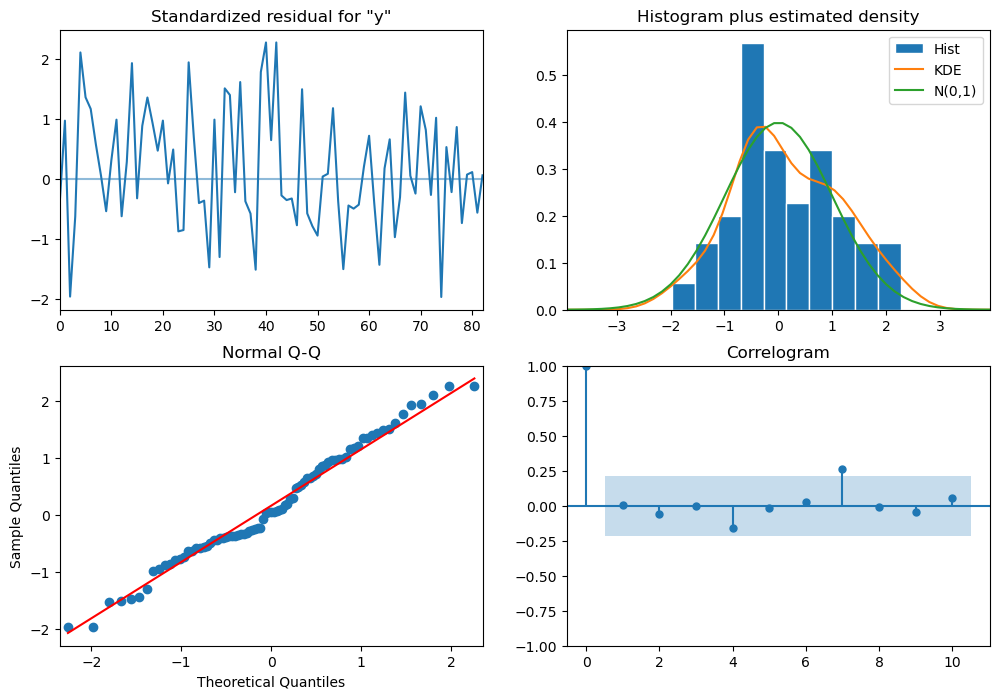

In [6]:
model_final = ARIMA(data_transformed, order=best_param_manual)
model_fit = model_final.fit()

# Summary
print(model_fit.summary())

# Diagnostic Plots
model_fit.plot_diagnostics(figsize=(12,8))
plt.show()


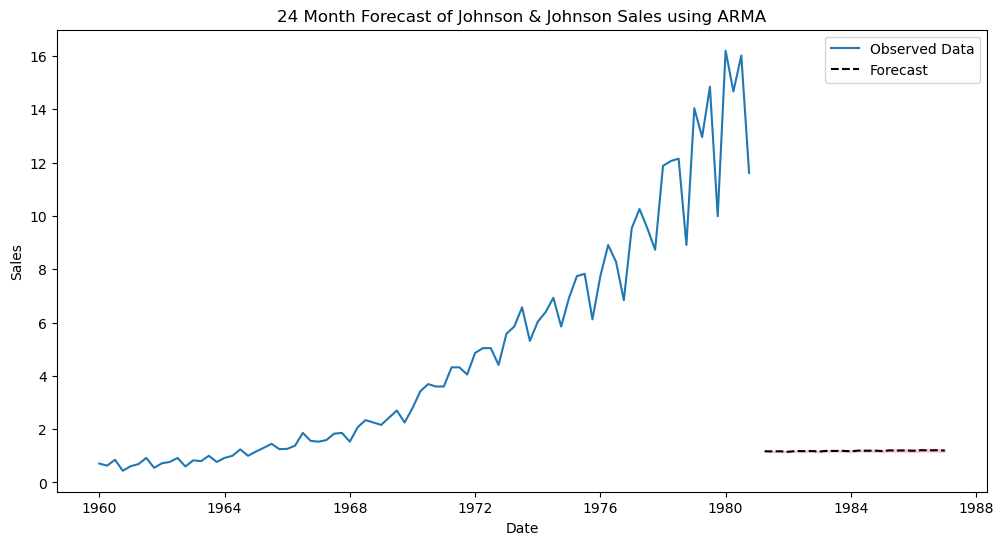

In [36]:
n_forecast = 24
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plot Forecast
plt.figure(figsize=(12,6))
plt.plot(data['data'], label='Observed Data')

forecast_index = pd.date_range(data.index[-1], periods=n_forecast+1, freq='Q')[1:]

# Plot Forecast Mean
plt.plot(forecast_index, np.exp(forecast_mean * lam), label='Forecast', color='black', linestyle='--')

# Plot Confidence Interval
plt.fill_between(forecast_index,
                 np.exp(forecast_ci[:, 0] * lam),
                 np.exp(forecast_ci[:, 1] * lam),
                 color='pink')

plt.title('24 Month Forecast of Johnson & Johnson Sales using ARMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()



In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler

# Reset data to original 
series = data['data'].values.reshape(-1, 1)

# Scaling the data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(series)

# Prepare Data for Supervised Learning
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 12  # Use previous 12 months to predict next month
X, y = create_sequences(scaled_data, sequence_length)

# Train-Test Split (80%-20%)
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (57, 12, 1)
y_train shape: (57, 1)
X_test shape: (15, 12, 1)
y_test shape: (15, 1)


In [10]:
# Build LSTM Model
lstm_model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')

# Train Model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - loss: 0.0398 - val_loss: 0.3044
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0279 - val_loss: 0.2133
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0201 - val_loss: 0.1316
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0073 - val_loss: 0.0656
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0055 - val_loss: 0.0261
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0070 - val_loss: 0.0196
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0061 - val_loss: 0.0236
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0051 - val_loss: 0.0342
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0035 - val_loss: 0.0399
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0037 - val_loss: 0.0328
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0029 - val_loss: 0.0238
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026 - val_loss: 0.0190


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step


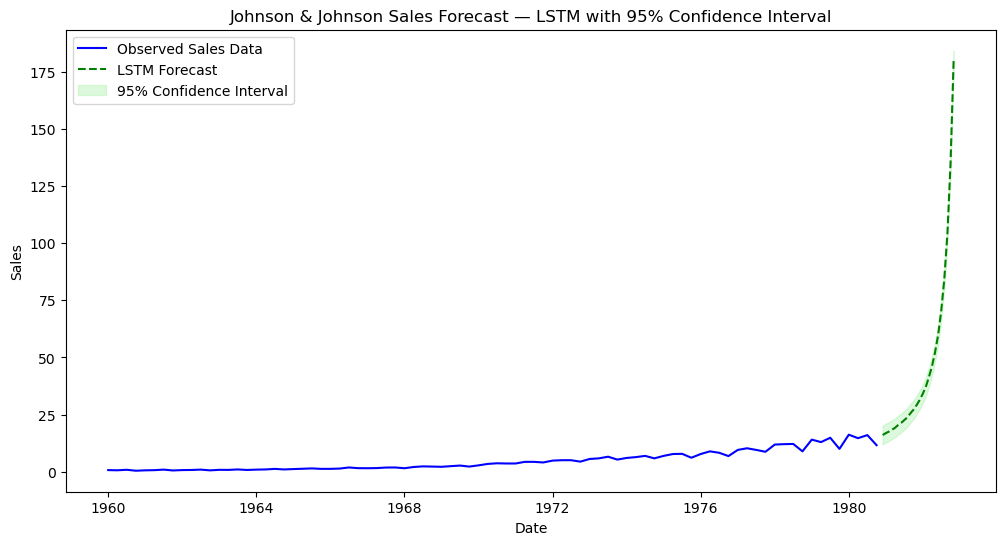

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Forecast Next 24 Months using LSTM
lstm_input = X_test[-1] 
lstm_forecast = []

for _ in range(24):
    pred = lstm_model.predict(lstm_input.reshape(1, sequence_length, 1), verbose=0)
    lstm_forecast.append(pred[0][0])
    lstm_input = np.append(lstm_input[1:], pred, axis=0)

# Inverse Transform Forecast to Original Scale
lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1))

# Calculate RMSE on Test Data for LSTM
lstm_test_pred = scaler.inverse_transform(lstm_model.predict(X_test).flatten().reshape(-1, 1))
rmse_lstm = np.sqrt(mean_squared_error(data['data'][-len(lstm_test_pred):], lstm_test_pred))

# Approximate 95% Confidence Interval
lstm_forecast_upper = lstm_forecast.flatten() + 1.96 * rmse_lstm
lstm_forecast_lower = lstm_forecast.flatten() - 1.96 * rmse_lstm

# Create Future Dates
future_dates = pd.date_range(start=data.index[-1], periods=25, freq='M')[1:]

# Plot Forecast with Confidence Interval
plt.figure(figsize=(12, 6))
plt.plot(data['data'], label='Observed Sales Data', color='blue')
plt.plot(future_dates, lstm_forecast, label='LSTM Forecast', color='green', linestyle='--')

# Plot Confidence Interval
plt.fill_between(future_dates, lstm_forecast_lower, lstm_forecast_upper, color='lightgreen', alpha=0.3, label='95% Confidence Interval')

plt.title('Johnson & Johnson Sales Forecast — LSTM with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [32]:
# Build GRU Model
gru_model = Sequential([
    GRU(64, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')

# Train Model
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 0.0413 - val_loss: 0.3176
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0268 - val_loss: 0.2083
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0145 - val_loss: 0.1264
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0079 - val_loss: 0.0754
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0064 - val_loss: 0.0519
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0049 - val_loss: 0.0444
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0037 - val_loss: 0.0460
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0029 - val_loss: 0.0432
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0026 - val_loss: 0.0333
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0019 - val_loss: 0.0244
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0017 - val_loss: 0.0215
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0014 - val_loss: 0.0215


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


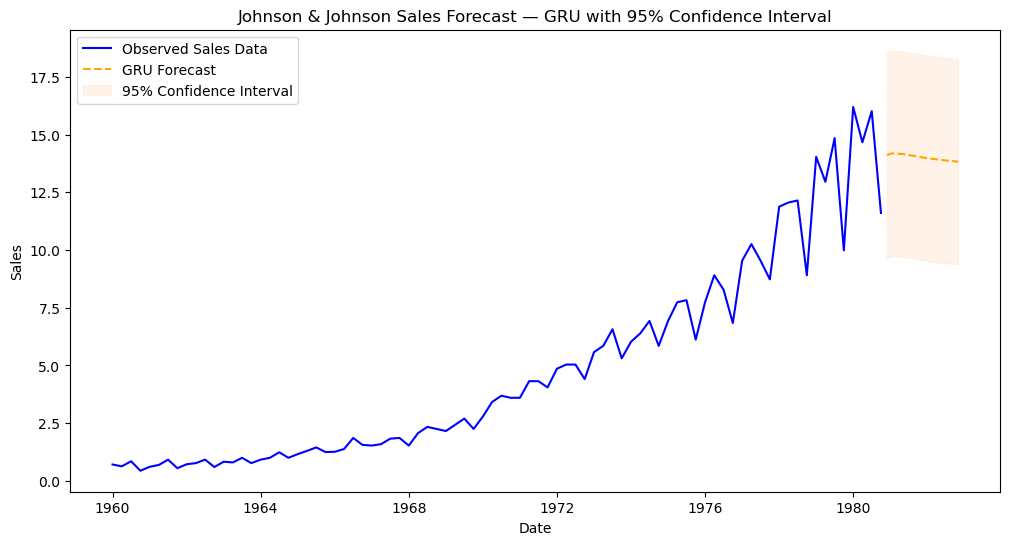

In [34]:
from sklearn.metrics import mean_squared_error

# Forecast Next 24 Months using GRU
gru_input = X_test[-1]  # Last known sequence
gru_forecast = []

for _ in range(24):
    pred = gru_model.predict(gru_input.reshape(1, sequence_length, 1), verbose=0)
    gru_forecast.append(pred[0][0])
    gru_input = np.append(gru_input[1:], pred, axis=0)

# Inverse Transform Forecast to Original Scale
gru_forecast = scaler.inverse_transform(np.array(gru_forecast).reshape(-1, 1))

# Calculate RMSE on Test Data for GRU
gru_test_pred = scaler.inverse_transform(gru_model.predict(X_test).flatten().reshape(-1, 1))
rmse_gru = np.sqrt(mean_squared_error(data['data'][-len(gru_test_pred):], gru_test_pred))

# Approximate 95% Confidence Interval
gru_forecast_upper = gru_forecast.flatten() + 1.96 * rmse_gru
gru_forecast_lower = gru_forecast.flatten() - 1.96 * rmse_gru

# Create Future Dates for Next 24 Months
future_dates = pd.date_range(start=data.index[-1], periods=25, freq='M')[1:]

# Plot Forecast with Confidence Interval
plt.figure(figsize=(12, 6))
plt.plot(data['data'], label='Observed Sales Data', color='blue')
plt.plot(future_dates, gru_forecast, label='GRU Forecast', color='orange', linestyle='--')

# Plot Confidence Interval
plt.fill_between(future_dates, gru_forecast_lower, gru_forecast_upper, color='peachpuff', alpha=0.3, label='95% Confidence Interval')

plt.title('Johnson & Johnson Sales Forecast — GRU with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Inverse transform LSTM and GRU predictions
lstm_pred = scaler.inverse_transform(lstm_model.predict(X_test)).flatten()
gru_pred = scaler.inverse_transform(gru_model.predict(X_test)).flatten()

# ARMA Predictions 
arma_pred = np.exp(model_fit.predict(start=0, end=len(data_transformed)-1) * lam)

# Actual Data for LSTM/GRU Evaluation
actual = data['data'][-len(lstm_pred):].values  # Convert to numpy array for safe operations

# ARMA Metrics
print("\n--- ARMA Model Metrics ---")
print(f'ARMA RMSE: {np.sqrt(mean_squared_error(data["data"], arma_pred)):.2f}')
print(f'ARMA MAE: {mean_absolute_error(data["data"], arma_pred):.2f}')
print(f'ARMA MAPE: {mape(data["data"], arma_pred):.2f}%')

# LSTM Metrics
print("\n--- LSTM Model Metrics ---")
print(f'LSTM RMSE: {np.sqrt(mean_squared_error(actual, lstm_pred)):.2f}')
print(f'LSTM MAE: {mean_absolute_error(actual, lstm_pred):.2f}')
print(f'LSTM MAPE: {mape(actual, lstm_pred):.2f}%')

# GRU Metrics
print("\n--- GRU Model Metrics ---")
print(f'GRU RMSE: {np.sqrt(mean_squared_error(actual, gru_pred)):.2f}')
print(f'GRU MAE: {mean_absolute_error(actual, gru_pred):.2f}')
print(f'GRU MAPE: {mape(actual, gru_pred):.2f}%')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

--- ARMA Model Metrics ---
ARMA RMSE: 5.64
ARMA MAE: 3.83
ARMA MAPE: 60.58%

--- LSTM Model Metrics ---
LSTM RMSE: 2.10
LSTM MAE: 1.70
LSTM MAPE: 14.66%

--- GRU Model Metrics ---
GRU RMSE: 9.19
GRU MAE: 8.90
GRU MAPE: 71.69%
